# ITS_LIVE temporal baseline sampling:
This notebook develops a workflow for determining the optimal temporal baseline sampling of ITS_LIVE velocity data for individual point along a glacier centerline. 

In [1]:
#| export 

import os
import json

import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon

import numpy as np
import pandas as pd

import scipy
from scipy.stats import invgauss

import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import matplotlib as mpl
import hvplot.pandas
import hvplot.xarray

import geoviews as gv
import geoviews.feature as gf

import s3fs
# to get and use geojson datacube catalog
import json
import logging
# for timing data access
import time

import numpy as np
import pyproj
import s3fs as s3
# for datacube xarray/zarr access
import xarray as xr
from pyproj import Transformer
# for plotting time series
from shapely import geometry

logging.basicConfig(level=logging.ERROR)
# import pandas as pd

In [8]:
#from itslivetools import s3access
#from itslivetools import datacube_tools

In [2]:
import warnings
warnings.filterwarnings("ignore")

## ITSLIVETOOLS

In [3]:
def get_bbox(input_xr, epsg = 'None'):
    '''returns geopandas geodataframe of bounding box of xarray object. 
    '''
    #if 'projection' in list(input_xr.attrs.keys()):

    #    proj_var = input_xr.projection
    #    epsg=proj_var
    #else: 
    #    epsg = proj_var
        #print('check name of projection var')
    
    xmin = input_xr.coords['x'].data.min()
    xmax = input_xr.coords['x'].data.max()

    ymin = input_xr.coords['y'].data.min()
    ymax = input_xr.coords['y'].data.max()

    pts_ls = [(xmin, ymin), (xmax, ymin),(xmax, ymax), (xmin, ymax), (xmin, ymin)]

    crs = epsg

    polygon_geom = Polygon(pts_ls)
    polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom]) 

    #polygon = polygon.to_crs('epsg:4326')

    return polygon

## DATACUBETOOLS

In [4]:
class DATACUBETOOLS:
    """
    class to encapsulate discovery and interaction with ITS_LIVE (its-live.jpl.nasa.gov) datacubes on AWS s3
    """

    VELOCITY_DATA_ATTRIBUTION = """ \nITS_LIVE velocity data
    (<a href="https://its-live.jpl.nasa.gov">ITS_LIVE</a>) with funding provided by NASA MEaSUREs.\n
    """

    def __init__(self, use_catalog="all"):
        """
        tools for accessing ITS_LIVE glacier velocity datacubes in S3
        __init__ reads in the geojson catalog of datacubes and creates list .open_cubes
        """
        # the URL for the current datacube catalog GeoJSON file - set up as dictionary to allow other catalogs for testing
        self.catalog = {
            "all": "s3://its-live-data/datacubes/catalog_v02.json",
        }

        self.transformer_3031 = Transformer.from_crs(4326, 3031, always_xy=True)

        self.elevation_dataset = xr.open_dataset(
            "s3://its-live-data/elevation/v01/ANT_G1920V01_GroundedIceHeight.zarr",
            engine="zarr",
            storage_options={"anon": True},
        )

        # S3fs used to access cubes in python
        self._s3fs = s3.S3FileSystem(anon=True)
        # keep track of open cubes so that we don't re-read xarray metadata and dimension vectors
        self.open_cubes = {}
        self._current_catalog = use_catalog
        with self._s3fs.open(self.catalog[use_catalog], "r") as incubejson:
            self._json_all = json.load(incubejson)
        self.json_catalog = self._json_all

    def load_elevation_timeseries(self, lon, lat):

        x_projected, y_projected = self.transformer_3031.transform(lon, lat)
        ts = (
            self.elevation_dataset["dh"]
            .sel(x=x_projected, y=y_projected, method="nearest")
            .to_dataframe()
            .dropna()
        )
        return ts["dh"]

    def find_datacube_catalog_entry_for_point(self, point_xy, point_epsg_str):
        """
        find catalog feature that contains the point_xy [x,y] in projection point_epsg_str (e.g. '3413')
        returns the catalog feature and the point_tilexy original point coordinates reprojected into the datacube's native projection
        (cubefeature, point_tilexy)
        """
        if point_epsg_str != "4326":
            # point not in lon,lat, set up transformation and convert it to lon,lat (epsg:4326)
            # because the features in the catalog GeoJSON are polygons in 4326
            inPROJtoLL = pyproj.Transformer.from_proj(
                f"epsg:{point_epsg_str}", "epsg:4326", always_xy=True
            )
            pointll = inPROJtoLL.transform(*point_xy)
        else:
            # point already lon,lat
            pointll = point_xy

        # create Shapely point object for inclusion test
        point = geometry.Point(*pointll)  # point.coords.xy

        # find datacube outline that contains this point in geojson index file
        cubefeature = None

        for f in self.json_catalog["features"]:
            polygeom = geometry.shape(f["geometry"])
            if polygeom.contains(point):
                cubefeature = f
                break

        if cubefeature:
            # find point x and y in cube native epsg if not already in that projection
            if point_epsg_str == str(cubefeature["properties"]["epsg"]):
                point_cubexy = point_xy
            else:
                inPROJtoTilePROJ = pyproj.Transformer.from_proj(
                    f"epsg:{point_epsg_str}",
                    f"EPSG:{cubefeature['properties']['epsg']}",
                    always_xy=True,
                )
                point_cubexy = inPROJtoTilePROJ.transform(*point_xy)

            print(
                f"original xy {point_xy} {point_epsg_str} maps to datacube {point_cubexy} "
                f"EPSG:{cubefeature['properties']['epsg']}"
            )

            # now test if point is in xy box for cube (should be most of the time; could fail
            # because of boundary curvature 4326 box defined by lon,lat corners but point needs to be in box defined in cube's projection)
            #
            point_cubexy_shapely = geometry.Point(*point_cubexy)
            polygeomxy = geometry.shape(cubefeature["properties"]["geometry_epsg"])
            if not polygeomxy.contains(point_cubexy_shapely):
                # first find cube proj bounding box
                dcbbox = np.array(
                    cubefeature["properties"]["geometry_epsg"]["coordinates"][0]
                )
                minx = np.min(dcbbox[:, 0])
                maxx = np.max(dcbbox[:, 0])
                miny = np.min(dcbbox[:, 1])
                maxy = np.max(dcbbox[:, 1])

                # point is in lat lon box, but not in cube-projection's box
                # try once more to find proper cube by using a new point in cube projection moved 10 km farther from closest
                # boundary in cube projection; use new point's lat lon to search for new cube - test if old point is in that
                # new cube's projection box, otherwise ...
                # this next section tries one more time to find new feature after offsetting point farther outside box of
                # first cube, in cube projection, to deal with curvature of lat lon box edges in different projections
                #
                # point in ll box but not cube_projection box, move point in cube projection
                # 10 km farther outside box, find new ll value for point, find new feature it is in,
                # and check again if original point falls in this new cube's
                # move coordinate of point outside this box farther out by 10 km

                newpoint_cubexy = list(point_cubexy)
                if point_cubexy[1] < miny:
                    newpoint_cubexy[1] -= 10000.0
                elif point_cubexy[1] > maxy:
                    newpoint_cubexy[1] += 10000.0
                elif point_cubexy[0] < minx:
                    newpoint_cubexy[0] -= 10000.0
                elif point_cubexy[0] > maxx:
                    newpoint_cubexy[0] += 10000.0
                else:
                    # no change has been made to newpoint_cubexy because
                    # user has chosen a point exactly on the boundary, move it 1 m into the box...
                    logging.info(
                        "user has chosen a point exactly on the boundary, move it 1 m into the box..."
                    )
                    if point_cubexy[1] == miny:
                        newpoint_cubexy[1] += 1.0
                    elif point_cubexy[1] == maxy:
                        newpoint_cubexy[1] -= 1.0
                    elif point_cubexy[0] == minx:
                        newpoint_cubexy[0] += 1.0
                    elif point_cubexy[0] == maxx:
                        newpoint_cubexy[0] -= 1.0

                # now reproject this point to lat lon and look for new feature
                if "data_epsg" in cubefeature["properties"]:
                    epsg_source = cubefeature["properties"]["data_epsg"]
                elif "projection" in cubefeaturea["properties"]:
                    epsg_source = cubefeature["properties"]["projection"]
                else:
                    epsg_source = None

                if epsg_source is None:
                    print("Source projection not found")
                    return None

                cubePROJtoLL = pyproj.Transformer.from_proj(
                    f'{cubefeature["properties"]["data_epsg"]}',
                    "epsg:4326",
                    always_xy=True,
                )
                newpointll = cubePROJtoLL.transform(*newpoint_cubexy)

                # create Shapely point object for inclusion test
                newpoint = geometry.Point(*newpointll)

                # find datacube outline that contains this point in geojson index file
                newcubefeature = None

                for f in self.json_catalog["features"]:
                    polygeom = geometry.shape(f["geometry"])
                    if polygeom.contains(newpoint):
                        newcubefeature = f
                        break

                if newcubefeature:
                    # if new feature found, see if original (not offset) point is in this new cube's cube-projection bounding box
                    # find point x and y in cube native epsg if not already in that projection
                    if (
                        cubefeature["properties"]["data_epsg"]
                        == newcubefeature["properties"]["data_epsg"]
                    ):
                        point_cubexy = newpoint_cubexy
                    else:
                        # project original point in this new cube's projection
                        inPROJtoTilePROJ = pyproj.Transformer.from_proj(
                            f"epsg:{point_epsg_str}",
                            newcubefeature["properties"]["data_epsg"],
                            always_xy=True,
                        )
                        point_cubexy = inPROJtoTilePROJ.transform(*point_xy)

                    logging.info(
                        f"try 2 original xy {point_xy} {point_epsg_str} with offset maps to new datacube {point_cubexy} "
                        f" {newcubefeature['properties']['data_epsg']}"
                    )

                    # now test if point is in xy box for cube (should be most of the time;
                    #
                    point_cubexy_shapely = geometry.Point(*point_cubexy)
                    polygeomxy = geometry.shape(
                        newcubefeature["properties"]["geometry_epsg"]
                    )
                    if not polygeomxy.contains(point_cubexy_shapely):
                        # point is in lat lon box, but not in cube-projection's box
                        # try once more to find proper cube by using a new point in cube projection moved 10 km farther from closest
                        # boundary in cube projection; use new point's lat lon to search for new cube - test if old point is in that
                        # new cube's projection box, otherwise fail...

                        raise timeseriesException(
                            f"point is in lat,lon box but not {cubefeature['properties']['data_epsg']} box!! even after offset"
                        )
                    else:
                        return (newcubefeature, point_cubexy)

            else:
                return (cubefeature, point_cubexy)

        else:
            print(f"No data for point (lon,lat) {pointll}")
            return (None, None)

    def get_timeseries_at_point(self, point_xy, point_epsg_str, variables=["v"]):
        """pulls time series for a point (closest ITS_LIVE point to given location):
        - calls find_datacube to determine which S3-based datacube the point is in,
        - opens that xarray datacube - which is also added to the open_cubes list, so that it won't need to be reopened (which can take O(5 sec) ),
        - extracts time series at closest grid cell to the original point
            (time_series.x and time_series.y contain x and y coordinates of ITS_LIVE grid cell in datacube projection)

        returns(
            - xarray of open full cube (not loaded locally, but coordinate vectors and attributes for full cube are),
            - time_series (as xarray dataset with all requested variables, that is loaded locally),
            - original point xy in datacube's projection
            )

        NOTE - returns an xarray Dataset (not just a single xarray DataArray) - time_series.v or time_series['v'] is speed
        """

        start = time.time()

        cube_feature, point_cubexy = self.find_datacube_catalog_entry_for_point(
            point_xy, point_epsg_str
        )

        if cube_feature is None:
            return (None, None, None)

        # for zarr store modify URL for use in boto open - change http: to s3: and lose s3.amazonaws.com
        incubeurl = (
            cube_feature["properties"]["zarr_url"]
            .replace("http:", "s3:")
            .replace(".s3.amazonaws.com", "")
        )

        # if we have already opened this cube, don't open it again
        if len(self.open_cubes) > 0 and incubeurl in self.open_cubes.keys():
            ins3xr = self.open_cubes[incubeurl]
        else:
            ins3xr = xr.open_dataset(
                incubeurl, engine="zarr", storage_options={"anon": True}
            )
            self.open_cubes[incubeurl] = ins3xr

        # find time series at the closest grid cell
        # NOTE - returns an xarray Dataset - pt_dataset.v is speed...
        pt_datset = ins3xr[variables].sel(
            x=point_cubexy[0], y=point_cubexy[1], method="nearest"
        )

        logging.info(
            f"xarray open - elapsed time: {(time.time()-start):10.2f}", flush=True
        )

        # pull data to local machine
        pt_datset.load()

        # print(
        #     f"time series loaded {[f'{x}: {pt_datset[x].shape[0]}' for x in variables]} points - elapsed time: {(time.time()-start):10.2f}",
        #     flush=True,
        # )
        # end for zarr store

        return (ins3xr, pt_datset, point_cubexy)

    def set_mapping_for_small_cube_from_larger_one(self, smallcube, largecube):
        """when a subset is pulled from an ITS_LIVE datacube, a new geotransform needs to be
        figured out from the smallcube's x and y coordinates and stored in the GeoTransform attribute
        of the mapping variable (which also needs to be copied from the original cube)
        """
        largecube_gt = [float(x) for x in largecube.mapping.GeoTransform.split(" ")]
        smallcube_gt = largecube_gt  # need to change corners still
        # find UL corner of UL pixel (x and y are pixel center coordinates)
        smallcube_gt[0] = smallcube.x.min().item() - (
            smallcube_gt[1] / 2.0
        )  # set new ul x value
        smallcube_gt[3] = smallcube.y.max().item() - (
            smallcube_gt[5] / 2.0
        )  # set new ul y value
        smallcube[
            "mapping"
        ] = largecube.mapping  # still need to add new GeoTransform as string
        smallcube.mapping["GeoTransform"] = " ".join([str(x) for x in smallcube_gt])
        return

    def get_subcube_around_point(
        self, point_xy, point_epsg_str, half_distance=5000.0, variables=["v"]
    ):
        """pulls subset of cube within half_distance of point (unless edge of cube is included) containing specified variables:
        - calls find_datacube to determine which S3-based datacube the point is in,
        - opens that xarray datacube - which is also added to the open_cubes list, so that it won't need to be reopened (which can take O(5 sec) ),
        - extracts smaller cube containing full time series of specified variables

        returns(
            - xarray of open full cube (not loaded locally, but coordinate vectors and attributes for full cube are),
            - smaller cube as xarray,
            - original point xy in datacube's projection
            )
        """

        start = time.time()

        cube_feature, point_cubexy = self.find_datacube_catalog_entry_for_point(
            point_xy, point_epsg_str
        )

        # for zarr store modify URL for use in boto open - change http: to s3: and lose s3.amazonaws.com
        incubeurl = (
            cube_feature["properties"]["zarr_url"]
            .replace("http:", "s3:")
            .replace(".s3.amazonaws.com", "")
        )

        # if we have already opened this cube, don't open it again
        if len(self.open_cubes) > 0 and incubeurl in self.open_cubes.keys():
            ins3xr = self.open_cubes[incubeurl]
        else:
            ins3xr = xr.open_dataset(
                incubeurl, engine="zarr", storage_options={"anon": True}
            )
            self.open_cubes[incubeurl] = ins3xr

        pt_tx, pt_ty = point_cubexy
        lx = ins3xr.coords["x"]
        ly = ins3xr.coords["y"]

        start = time.time()
        small_ins3xr = (
            ins3xr[variables]
            .loc[
                dict(
                    x=lx[(lx > pt_tx - half_distance) & (lx < pt_tx + half_distance)],
                    y=ly[(ly > pt_ty - half_distance) & (ly < pt_ty + half_distance)],
                )
            ]
            .load()
        )
        print(f"subset and load at {time.time() - start:6.2f} seconds", flush=True)

        # now fix the CF compliant geolocation/mapping of the smaller cube
        self.set_mapping_for_small_cube_from_larger_one(small_ins3xr, ins3xr)

        return (ins3xr, small_ins3xr, point_cubexy)

    def get_subcube_for_bounding_box(self, bbox, bbox_epsg_str, variables=["v"]):
        """pulls subset of cube within bbox (unless edge of cube is included) containing specified variables:
        - calls find_datacube to determine which S3-based datacube the bbox central point is in,
        - opens that xarray datacube - which is also added to the open_cubes list, so that it won't need to be reopened (which can take O(5 sec) ),
        - extracts smaller cube containing full time series of specified variables

        bbox = [ minx, miny, maxx, maxy ] in bbox_epsg_str meters
        bbox_epsg_str = '3413', '32607', '3031', ... (EPSG:xxxx) projection identifier
        variables = [ 'v', 'vx', 'vy', ...] variables in datacube - note 'mapping' is returned by default, with updated geotransform attribute for the new subcube size

        returns(
            - xarray of open full cube (not loaded locally, but coordinate vectors and attributes for full cube are),
            - smaller cube as xarray (loaded to memory),
            - original bbox central point xy in datacube's projection
            )
        """

        start = time.time()

        #
        # derived from point/distance (get_subcube_around_point) so first iteration uses central point to look up datacube to open
        # subcube will still be clipped at datacube edge if bbox extends to other datacubes - in future maybe return subcubes from each?
        #
        # bbox is probably best expressed in datacube epsg - will fail if different...  in future, deal with this some other way.
        #

        bbox_minx, bbox_miny, bbox_maxx, bbox_maxy = bbox
        bbox_centrer_point_xy = [
            (bbox_minx + bbox_maxx) / 2.0,
            (bbox_miny + bbox_maxy) / 2.0,
        ]
        (
            cube_feature,
            bbox_centrer_point_cubexy,
        ) = self.find_datacube_catalog_entry_for_point(
            bbox_centrer_point_xy, bbox_epsg_str
        )

        if cube_feature["properties"]["data_epsg"].split(":")[-1] != bbox_epsg_str:
            print(
                f'bbox is in epsg:{bbox_epsg_str}, should be in datacube {cube_feature["properties"]["data_epsg"]}'
            )
            return None

        # for zarr store modify URL for use in boto open - change http: to s3: and lose s3.amazonaws.com
        incubeurl = (
            cube_feature["properties"]["zarr_url"]
            .replace("http:", "s3:")
            .replace(".s3.amazonaws.com", "")
        )

        # if we have already opened this cube, don't open it again
        if len(self.open_cubes) > 0 and incubeurl in self.open_cubes.keys():
            ins3xr = self.open_cubes[incubeurl]
        else:
            # open zarr format xarray datacube on AWS S3
            ins3xr = xr.open_dataset(
                incubeurl, engine="zarr", storage_options={"anon": True}
            )
            self.open_cubes[incubeurl] = ins3xr

        lx = ins3xr.coords["x"]
        ly = ins3xr.coords["y"]

        start = time.time()
        small_ins3xr = (
            ins3xr[variables]
            .loc[
                dict(
                    x=lx[(lx >= bbox_minx) & (lx <= bbox_maxx)],
                    y=ly[(ly >= bbox_miny) & (ly <= bbox_maxy)],
                )
            ]
            .load()
        )
        print(f"subset and load at {time.time() - start:6.2f} seconds", flush=True)

        # now fix the CF compliant geolocation/mapping of the smaller cube
        self.set_mapping_for_small_cube_from_larger_one(small_ins3xr, ins3xr)

        return (ins3xr, small_ins3xr, bbox_centrer_point_cubexy)


In [5]:
#| hide 
from nbdev.showdoc import *
import nbdev
from nbdev import nbdev_export

## Read in RGI

In [6]:
data_dir = '/uufs/chpc.utah.edu/common/home/u1269862/'
rgi_14 = 'rgi/14_rgi60_SouthAsiaWest.shp'
rgi_14 = gpd.read_file(os.path.join(data_dir, rgi_14))
baltoro_rgi = rgi_14.loc[rgi_14['RGIId'] == 'RGI60-14.06794']
baltoro_rgi_utm = baltoro_rgi.to_crs('EPSG:32643')
baltoro_rgi_102027 = baltoro_rgi.to_crs('ESRI:102027')

## Read in centerline data

In [7]:
#oggm_dir = '/home/emmamarshall/Desktop/phd_work/oggm/flowlines/'
#fl_13_path = 'flowlines_13/flowlines_13.shp'
fl_14_path = 'oggm_flowlines/flowlines_14.shp'
#fl_15_path = 'flowlines_15/flowlines_15.shp'

#fl_13 = gpd.read_file(os.path.join(oggm_dir, fl_13_path))
fl_14 = gpd.read_file(os.path.join(data_dir, fl_14_path))
#fl_15 = gpd.read_file(os.path.join(oggm_dir, fl_15_path))

In [8]:
fl_14_utm = fl_14.to_crs('EPSG:32643')

In [9]:
fl_baltoro_main = fl_14_utm.loc[(fl_14_utm['RGIID'] == 'RGI60-14.06794') & (fl_14_utm['MAIN'] == 1)]

## Read in itslive mosaic data

In [14]:
mosaic = xr.open_dataset('/uufs/chpc.utah.edu/common/home/cryosphere/emarshall/HMA_G0120_0000.nc')
mosaic = mosaic.rio.write_crs('ESRI:102027')

In [16]:
point = [76.3797, 35.7376]

## Format data

### Roadmap
1. user enters RGI ID and this will create a glacierData (class) object containing:
- outline (gdf), main flowline from OGGM (gdf), points gdf
2. point velocity data (tbd setpu)
  - for now, user will enter point, eventually could automate based on rgiid and flowline?
  - once have point, automatically pull datacube for that point (and 3 surrounding points, or something like that, but still figuring out)
  - for now maybe use the points df to extract 2 points nearby, then extract datacube, then average them together for each time step? 
3. for that point, check velocity mosaic, return long term median flow speed at that point (calc off of x,y if possible)
4. using this point speed, calculate minimum temporal baselines for each sensor
5. return dataset after temporal baseline filtering

### Long-term flow data
- still trying to figure out the best way to examine long term glacier flow. Started by using an itslive mosaic extracted along OGGM flowlines, then calculating a median along the entire glacier flowline. However, this doesn't feel very representative -- Baltoro example shows very different flow speeds at different points along a flowline (from image pair data, haven't looked at mosaic as explicitly yet)

#### Potential approach
Decide on a set mosaic to work from -- ind year, multi-year but 1 file. For a given glacier, clip full raster to flowline, then extract ind points along flowline? might not be scalable...

### Practice

In [237]:
class Person():
    # method that runs as soon as you create an instance of a class (initializes)
    def __init__(self, name, age, color): #method that runs as soon as class created
        #assign init args to class as attrs
        self.name = name
        self.age = age
        self.color = color
    #date of birth method
    def year_of_birth(self):
        return 2023-self.age
    #project age
    def projected_age(self, years=5):
        return self.age + years

In [238]:
class Astronaut(Person):
    def __init__(self, name, age, color, mission_length_months):
        super().__init__(name, age, color)
        self.mission_length_months = mission_length_months
    #create new method for calc age on return
    
    def age_on_return(self):
        return self.projected_age(years = int(self.mission_length_months/12))

In [239]:
new_person = Person('Emma',30, 'teal')

In [240]:
new_astronaut = Astronaut('Micah',31, 'blue', 24)

In [241]:
new_person.projected_age(10)

40

In [242]:
#access parent-like attr
new_astronaut.color

'blue'

In [243]:
new_astronaut.age_on_return()

33

# utility fns

In [10]:
#| export
def point_to_gdf(point, crs):
    
    d = {'x': point[0],
         'y':point[1]}
    df = pd.DataFrame(d, index=[0])
    gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.x, df.y, crs=crs))
    return gdf

## defining classes

In [11]:
class MyGlacier:

    def __init__(self, name, id, rgi_gpdf, oggm_gpdf, its_mosaic):
        self.name = name
        self.id = id
        self.outline = self.add_outline(rgi_gpdf)
        self.flowline = self.add_flowline(oggm_gpdf)
        self.mosaic = self.add_mosaic(self.outline, its_mosaic)
        #self.point_mosaic = self.extract_mosaic_at_point(self, point, self.mosaic)
        
    def add_outline(self, rgi_gpdf):
        id_gpdf = rgi_gpdf.loc[rgi_gpdf['RGIId'] == self.id]
        return id_gpdf
        
    def add_flowline(self, oggm_gpdf):
        id_gpdf = oggm_gpdf.loc[oggm_gpdf['RGIID'] == self.id]
        main_gpdf = id_gpdf.loc[id_gpdf['MAIN'] == 1]
        return main_gpdf

    def add_mosaic(self, outline, its_mosaic):

        outline_prj = self.outline.to_crs('ESRI:102027')
        mosaic_clip = its_mosaic.rio.clip(outline_prj.geometry, outline_prj.crs)
        
        return mosaic_clip
        
    def extract_mosaic_at_point(self, point):

        gdf_point = point_to_gdf(point, 'EPSG:4326')
        point_gdf_102027 = gdf_point.to_crs('ESRI:102027')
        mosaic_point = self.mosaic.rio.clip(point_gdf_102027.geometry, point_gdf_102027.crs)
            
        return mosaic_point
    

In [136]:
#now, want to define a child class, point, that inherits from parent class glacier
class MyPoint(MyGlacier):
    
    #init fn needs all the arguments that myglacier expects as well as ones spec. to mypoint 
    def __init__(self, name, id, rgi_gpdf, oggm_gpdf, its_mosaic, point, location_label):
        #this is what gives us inheritance
        super().__init__(name, id, rgi_gpdf, oggm_gpdf, its_mosaic)
        self.point = point
        self.location_label = location_label
        self.median_v = self.extract_mosaic_at_point(point).v[0][0]
        self.image_pair_subcube = self.add_image_pair_data(self)[0]
        self.image_pair_point = self.add_image_pair_data(self)[2]
        self.point_utm = self.add_image_pair_data(self)[1]
        
    def add_image_pair_data(self, point_epsg_str):
        
        dc = DATACUBETOOLS()
        dc_point = dc.get_timeseries_at_point(self.point, point_epsg_str='4326', variables = ['v','vy','vx','v_error','satellite_img1','satellite_img2'])[1]
        dc_point = dc_point.dropna(how='all', dim='mid_date')
        dc_point = dc_point.rio.write_crs(f"EPSG:{dc_point.mapping.attrs['spatial_epsg']}")
        prod = dc.get_subcube_around_point(self.point, point_epsg_str='4326', variables = ['v','vy','vx','v_error','satellite_img1','satellite_img2'])
        dc_sub, point_in_local_utm = prod[1], prod[2]
        dc_sub = dc_sub.dropna(how='all', dim='mid_date')
        dc_sub = dc_sub.rio.write_crs(f"EPSG:{dc_sub.mapping.attrs['spatial_epsg']}")
        return dc_sub, point_in_local_utm, dc_point
    


In [95]:
class Satellite():

    def __init__(self, name, id, gsd):

        self.name = name
        self.id = id
        self.gsd = gsd

In [99]:
landsat8 = Satellite('Landsat-8','L8', 30)
sentinel1 = Satellite('Sentinel-1','S1', 10)
sentinel2 = Satellite('Sentinel-2','S2', 10)

In [98]:
landsat8.gsd

30

In [31]:
baltoro = MyGlacier('Baltoro', 'RGI60-14.06794', rgi_14, fl_14, mosaic)


In [130]:
baltoroPoint = MyPoint('Baltoro','RGI60-14.06794', rgi_14, fl_14, mosaic, point, 'mid-glacier') #add 'mid_point' or somehting like that next time this runs

original xy [76.3797, 35.7376] 4326 maps to datacube (624763.5766152533, 3955722.574253059) EPSG:32643
original xy [76.3797, 35.7376] 4326 maps to datacube (624763.5766152533, 3955722.574253059) EPSG:32643
subset and load at  18.15 seconds
original xy [76.3797, 35.7376] 4326 maps to datacube (624763.5766152533, 3955722.574253059) EPSG:32643
original xy [76.3797, 35.7376] 4326 maps to datacube (624763.5766152533, 3955722.574253059) EPSG:32643
subset and load at  16.25 seconds
original xy [76.3797, 35.7376] 4326 maps to datacube (624763.5766152533, 3955722.574253059) EPSG:32643
original xy [76.3797, 35.7376] 4326 maps to datacube (624763.5766152533, 3955722.574253059) EPSG:32643
subset and load at  15.68 seconds


In [132]:
baltoroPoint

### Visualize data 

In [51]:
#vector data (latlon)
baltoro.flowline.hvplot(color='red')*baltoro.outline.hvplot(alpha=0.2)*point_to_gdf(point, 'EPSG:4326').hvplot()

:Overlay
   .Path.I     :Path   [x,y]
   .Polygons.I :Polygons   [x,y]
   .Points.I   :Points   [x,y]

In [52]:
#mosaic raster (ESRI:102027)
baltoro.mosaic.v.hvplot()

:Image   [x,y]   (v)

In [133]:
baltoroPoint.median_v.data

array(109.02552, dtype=float32)

In [135]:
baltoroPoint.image_pair_point.isel(mid_date=1)

<xarray.Dataset>
Dimensions:         ()
Coordinates:
    mid_date        datetime64[ns] 2021-07-11T05:48:51.036076032
    x               float64 6.248e+05
    y               float64 3.956e+06
Data variables:
    v               float32 nan
    vy              float32 nan
    vx              float32 nan
    v_error         float32 nan
    satellite_img1  <U32 '2B'
    satellite_img2  <U32 '2B'
Attributes: (12/18)
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               14-Jun-2022 04:36:00
    date_updated:               14-Jun-2022 04:36:00
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v02/N30E070/ITS_...
    skipped_granules:           s3://its-live-data/datacubes/v02/N30E070/ITS_...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image_pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

## Trying to build [starter] temporal baseline filter

In [102]:
baltoroPoint.median_v.data

array(109.02552, dtype=float32)

In [149]:
a  = baltoroPoint.image_pair_point.dropna(how='any', dim='mid_date')

In [164]:
a_8 = a.where(a.satellite_img1 == '8.0', drop=True)

In [169]:
s_2 = a.where(a.satellite_img1 == '2A', drop=True)

In [170]:
s_2

<xarray.Dataset>
Dimensions:         (mid_date: 350)
Coordinates:
  * mid_date        (mid_date) datetime64[ns] 2020-02-12T05:49:11.035076096 ....
    x               float64 6.248e+05
    y               float64 3.956e+06
Data variables:
    v               (mid_date) float32 107.0 65.0 108.0 ... 134.0 188.0 163.0
    vy              (mid_date) float32 -14.0 -17.0 15.0 ... -32.0 46.0 20.0
    vx              (mid_date) float32 -106.0 -63.0 -106.0 ... -182.0 -162.0
    v_error         (mid_date) float32 2.0 7.0 43.0 3.0 ... 11.0 20.0 183.0 21.0
    satellite_img1  (mid_date) object '2A' '2A' '2A' '2A' ... '2A' '2A' '2A'
    satellite_img2  (mid_date) object '2A' '2B' '2B' '2A' ... '2A' '2B' '2B'
Attributes: (12/18)
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               14-Jun-2022 04:36:00
    date_updated:               14-Jun-2022 04:36:00
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v02/N30E070/ITS_...
    skipped_granules:           s3://its-live-data/datacubes/v02/N30E070/ITS_...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image_pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

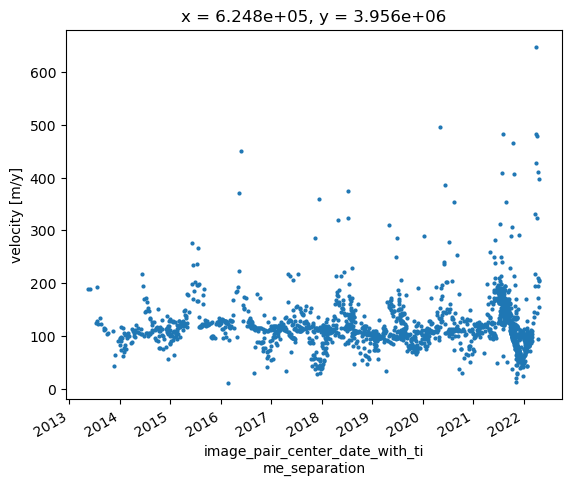

In [154]:
a.v.plot(marker='o', linestyle='None', markersize=2)

In [15]:
def format_flowline_points(flowline_gdf):
    #convert from linestring feature to gpdf of points
    fl_points = flowline_gdf.get_coordinates()
    fl_points = gpd.GeoDataFrame(fl_points,
                                 geometry = gpd.points_from_xy(fl_points.x, fl_points.y, crs = flowline_gdf.crs)
                                )
    #add a column with distance from first point (should be glacier head)
    fl_points['dist_from_0'] = fl_points['geometry'].distance(fl_points.iloc[0]['geometry'])
    fl_points['dist_from_prev'] = fl_points.distance(fl_points.shift(1))

    return fl_points


In [16]:
baltoro_points = format_flowline_points(fl_baltoro_main)

In [17]:
baltoro_points_prj = baltoro_points.to_crs('ESRI:102027')

In [34]:
baltoro_points_prj.crs

<Projected CRS: ESRI:102027>
Name: Asia_North_Lambert_Conformal_Conic
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Asia - North
- bounds: (25.0, 10.0, -175.0, 85.0)
Coordinate Operation:
- name: Asia_North_Lambert_Conformal_Conic
- method: Lambert Conic Conformal (2SP)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
dc_bbox = s3access.get_bbox(dc[0], epsg = dc[0].mapping.attrs['spatial_epsg'])

In [ ]:
dc[2]
df = pd.DataFrame({'label':'datacube_point',
                   'lat': dc[2][1],
                   'lon': dc[2][0]},
                 index=[0])

In [ ]:
m = dcsub_bbox.hvplot()*baltoro_rgi_utm.hvplot()*fl_baltoro_main.hvplot(color='red')*dc_point.hvplot(color='purple')

In [ ]:
m

:Overlay
   .Polygons.I  :Polygons   [x,y]
   .Polygons.II :Polygons   [x,y]
   .Path.I      :Path   [x,y]
   .Points.I    :Points   [x,y]